<a href="https://colab.research.google.com/github/YanaAbakumova/Neural_networks/blob/lesson_6/Lesson6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Практическое задание

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
2. Опишите  результата. Что помогло повысить точность?

In [129]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [130]:
# в качестве тренировочной выборки взято 40 фото, в качестве тестовой - 10
train_path = '/content/drive/MyDrive/cityscapes_data/train/'
test_path = '/content/drive/MyDrive/cityscapes_data/val/'

In [131]:
import os, fnmatch
images_train = os.listdir(train_path)
images_test = os.listdir(test_path)

In [132]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [133]:
X_img = []
y_img = []
for i_name in images_train:
  im = Image.open(train_path+i_name)
  width, height = im.size
  X_img.append(im.crop((0,0, width/2, height)))
  y_img.append(im.crop((width/2,0, width, height)))


In [134]:
X_val_img = []
y_val_img = []
for i_name in images_test:
  im = Image.open(test_path+i_name)
  width, height = im.size
  X_val_img.append(im.crop((0,0, width/2, height)))
  y_val_img.append(im.crop((width/2,0, width, height)))

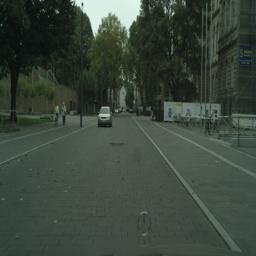

In [135]:
X_img[0]

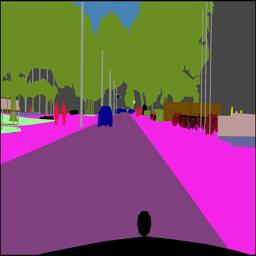

In [136]:
y_img[0]

In [137]:
X_train = np.array([image.img_to_array(X_img[i]) for i in range (len(X_img))])

In [138]:
X_test = np.array([image.img_to_array(X_val_img[i]) for i in range (len(X_val_img))])

In [139]:
segments = [image.img_to_array(y_img[i]) for i in range (len(y_img))]

In [140]:
test_segments = np.array([image.img_to_array(y_val_img[i]) for i in range (len(y_val_img))])

In [141]:
classes = np.array([i.reshape(i.shape[0]*i.shape[1], 3) for i in segments])
classes = classes.reshape((classes.shape[0]*classes.shape[1],3))

In [142]:
classes.shape

(2621440, 3)

In [143]:
kmeans = KMeans(12)
kmeans.fit(classes)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

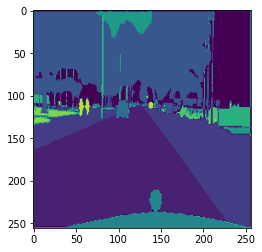

In [144]:
def Color2index(y):
  dict_col= {0:[0,0,255],1:[255,0,0], 2: [255,255,0],3: [0,255,0],4: [255,0,255],5: [0,255,255],6: [255,0,153], 7: [153,0,255],8: [0,153,255],9: [153,255,0],10: [255,153,0],11:[0,0,0]}
  pred = kmeans.predict(np.array(y).reshape(-1,3))
  y = np.array([dict_col[i] for i in pred]).reshape(256,256,3)
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(dict_col)))
  i = 1
  for i_color in dict_col.values():
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(segments[0])
plt.imshow(ind_yi.astype(float)/h)
plt.show()  

In [145]:
y_train = []

for seg in segments:
  y_cat,_,_ = Color2index(seg)
  y_train.append(y_cat)

y_train = np.array(y_train)

In [146]:
y_test = []

for seg in test_segments:
  y_cat,_,_ = Color2index(seg)
  y_test.append(y_cat)

y_test = np.array(y_test)

In [147]:
y_train.shape

(40, 256, 256, 12)

In [148]:
X_train.shape

(40, 256, 256, 3)

In [149]:
y_test.shape

(10, 256, 256, 12)

In [150]:
X_test.shape

(10, 256, 256, 3)

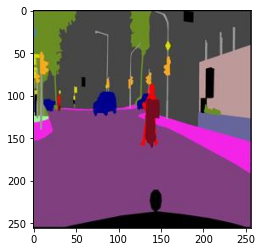

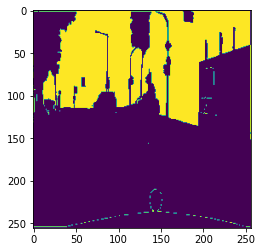

In [151]:
n = 1
plt.imshow(y_img[n].convert('RGBA'))
plt.show()
img = y_train[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

In [152]:
X_train = X_train/255
X_test = X_test/255

In [175]:
def Unet(num_classes = 12, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

 #   x = MaxPooling2D()(block_4_out)

    # Block 5
  #  x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
   # x = BatchNormalization()(x)
   # x = Activation('relu')(x)

   # x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
   # x = BatchNormalization()(x)
   # x = Activation('relu')(x)

   # x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
   # x = BatchNormalization()(x)
   # block_5_out = Activation('relu')(x)

   # x = MaxPooling2D()(block_5_out)

    # UP 1
  #  x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
  #  x = BatchNormalization()(x)
  #  x = Activation('relu')(x)

  #  x = concatenate([x, block_4_out])
   # x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

       # UP 5
   # x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
  #  x = BatchNormalization()(x)
   # x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
   # x = concatenate([x, block_1_out])
   # x = Conv2D(32, (3, 3), padding='same')(x)
   # x = BatchNormalization()(x)
   # x = Activation('relu')(x)

   # x = Conv2D(32, (3, 3), padding='same')(x)
   # x = BatchNormalization()(x)
   # x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [176]:
model = Unet(12, (256, 256, 3))

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_487 (BatchN (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_369 (Activation)     (None, 256, 256, 64) 0           batch_normalization_487[0][0]    
___________________________________________________________________________________________

In [155]:
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/10
4/4 [==============================] - 8s 2s/step - loss: 2.0848 - dice_coef: 0.1993 - val_loss: 2.4490 - val_dice_coef: 0.0868
Epoch 2/10
4/4 [==============================] - 5s 1s/step - loss: 1.3865 - dice_coef: 0.4225 - val_loss: 4.6070 - val_dice_coef: 0.0874
Epoch 3/10
4/4 [==============================] - 5s 1s/step - loss: 1.2165 - dice_coef: 0.4767 - val_loss: 29.2986 - val_dice_coef: 0.1100
Epoch 4/10
4/4 [==============================] - 5s 1s/step - loss: 1.1585 - dice_coef: 0.4966 - val_loss: 15.1408 - val_dice_coef: 0.1207
Epoch 5/10
4/4 [==============================] - 5s 1s/step - loss: 1.0688 - dice_coef: 0.5136 - val_loss: 24.5177 - val_dice_coef: 0.1193
Epoch 6/10
4/4 [==============================] - 5s 1s/step - loss: 1.0203 - dice_coef: 0.5389 - val_loss: 15.3695 - val_dice_coef: 0.1193
Epoch 7/10
4/4 [==============================] - 5s 1s/step - loss: 0.9650 - dice_coef: 0.5548 - val_loss: 6.6534 - val_dice_coef: 0.1271
Epoch 8/10
4/4 [=======

In [174]:
# меньше batch size - не очень стабильный результат
history2 = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_test, y_test))

Epoch 1/10
40/40 [==============================] - 14s 286ms/step - loss: 1.5704 - dice_coef: 0.3833 - val_loss: 44.1805 - val_dice_coef: 0.0567
Epoch 2/10
40/40 [==============================] - 10s 247ms/step - loss: 1.1998 - dice_coef: 0.4639 - val_loss: 6.7231 - val_dice_coef: 0.0846
Epoch 3/10
40/40 [==============================] - 10s 259ms/step - loss: 1.0617 - dice_coef: 0.5191 - val_loss: 2.8544 - val_dice_coef: 0.3547
Epoch 4/10
40/40 [==============================] - 10s 258ms/step - loss: 1.0759 - dice_coef: 0.5049 - val_loss: 3.2676 - val_dice_coef: 0.3153
Epoch 5/10
40/40 [==============================] - 10s 246ms/step - loss: 1.0224 - dice_coef: 0.5365 - val_loss: 5.3150 - val_dice_coef: 0.1359
Epoch 6/10
40/40 [==============================] - 10s 258ms/step - loss: 0.9733 - dice_coef: 0.5523 - val_loss: 3.1448 - val_dice_coef: 0.2830
Epoch 7/10
40/40 [==============================] - 10s 258ms/step - loss: 0.9378 - dice_coef: 0.5564 - val_loss: 3.6492 - val_di

In [177]:
# средний batch size
history3 = model.fit(X_train, y_train, epochs=10, batch_size=5, validation_data=(X_test, y_test))

Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.9479 - dice_coef: 0.2424 - val_loss: 10.7372 - val_dice_coef: 0.0850
Epoch 2/10
8/8 [==============================] - 8s 1s/step - loss: 1.3709 - dice_coef: 0.4068 - val_loss: 11.6365 - val_dice_coef: 0.0982
Epoch 3/10
8/8 [==============================] - 7s 929ms/step - loss: 1.2019 - dice_coef: 0.4732 - val_loss: 6.1933 - val_dice_coef: 0.0854
Epoch 4/10
8/8 [==============================] - 7s 924ms/step - loss: 1.0977 - dice_coef: 0.5092 - val_loss: 4.2948 - val_dice_coef: 0.1028
Epoch 5/10
8/8 [==============================] - 7s 927ms/step - loss: 1.0312 - dice_coef: 0.5296 - val_loss: 5.6361 - val_dice_coef: 0.1254
Epoch 6/10
8/8 [==============================] - 7s 922ms/step - loss: 0.9858 - dice_coef: 0.5507 - val_loss: 3.1633 - val_dice_coef: 0.0863
Epoch 7/10
8/8 [==============================] - 8s 1s/step - loss: 0.9328 - dice_coef: 0.5620 - val_loss: 3.4905 - val_dice_coef: 0.0872
Epoch 8/10
8

In [160]:
# больше блоков (раскомментирован блок 4 - оказался лишним)
history4 = model.fit(X_train, y_train, epochs=10, batch_size=5, validation_data=(X_test, y_test))

Epoch 1/10
8/8 [==============================] - 13s 1s/step - loss: 1.8745 - dice_coef: 0.2745 - val_loss: 75.7540 - val_dice_coef: 0.0954
Epoch 2/10
8/8 [==============================] - 9s 1s/step - loss: 1.3232 - dice_coef: 0.4463 - val_loss: 395.9813 - val_dice_coef: 0.1200
Epoch 3/10
8/8 [==============================] - 9s 1s/step - loss: 1.1715 - dice_coef: 0.4804 - val_loss: 160.2849 - val_dice_coef: 0.1202
Epoch 4/10
8/8 [==============================] - 8s 1s/step - loss: 1.0546 - dice_coef: 0.5287 - val_loss: 116.7519 - val_dice_coef: 0.1193
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 1.0255 - dice_coef: 0.5372 - val_loss: 24.4049 - val_dice_coef: 0.1303
Epoch 6/10
8/8 [==============================] - 9s 1s/step - loss: 0.9508 - dice_coef: 0.5607 - val_loss: 27.2596 - val_dice_coef: 0.1234
Epoch 7/10
8/8 [==============================] - 9s 1s/step - loss: 0.9643 - dice_coef: 0.5754 - val_loss: 30.5269 - val_dice_coef: 0.1259
Epoch 8/10
8/8 [

In [161]:
 pre_trained_model = VGG16(input_shape=X_test.shape[1:], include_top=False, weights="imagenet")

In [162]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [163]:
def unet_pre_train(num_classes = 12, input_shape= (256, 256, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[12].output # конец сверток
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output # первое уменьшение размера
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x, block_4_out, numb_filter = [256,128])
    

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_3_out, numb_filter = [128,64])
    

    # UP 3
  

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_2_out, numb_filter = [64,32])


    # UP 4
   
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [164]:
modelU = unet_pre_train(num_classes = 12, input_shape= (256, 256, 3))

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_30[0][0]        

In [165]:
history5 = modelU.fit(X_train, y_train, epochs=10, batch_size=5, validation_data=(X_test, y_test))

Epoch 1/10
8/8 [==============================] - 5s 434ms/step - loss: 1.9665 - dice_coef: 0.2407 - val_loss: 2.8441 - val_dice_coef: 0.1105
Epoch 2/10
8/8 [==============================] - 3s 402ms/step - loss: 1.2426 - dice_coef: 0.5010 - val_loss: 3.7615 - val_dice_coef: 0.1757
Epoch 3/10
8/8 [==============================] - 3s 401ms/step - loss: 0.9865 - dice_coef: 0.5936 - val_loss: 4.9845 - val_dice_coef: 0.1510
Epoch 4/10
8/8 [==============================] - 3s 399ms/step - loss: 0.8541 - dice_coef: 0.6267 - val_loss: 5.7612 - val_dice_coef: 0.0903
Epoch 5/10
8/8 [==============================] - 3s 365ms/step - loss: 0.7567 - dice_coef: 0.6668 - val_loss: 6.3840 - val_dice_coef: 0.1252
Epoch 6/10
8/8 [==============================] - 3s 367ms/step - loss: 0.7354 - dice_coef: 0.6691 - val_loss: 5.6520 - val_dice_coef: 0.1239
Epoch 7/10
8/8 [==============================] - 3s 402ms/step - loss: 0.6862 - dice_coef: 0.6970 - val_loss: 5.0298 - val_dice_coef: 0.1284
Epoch 

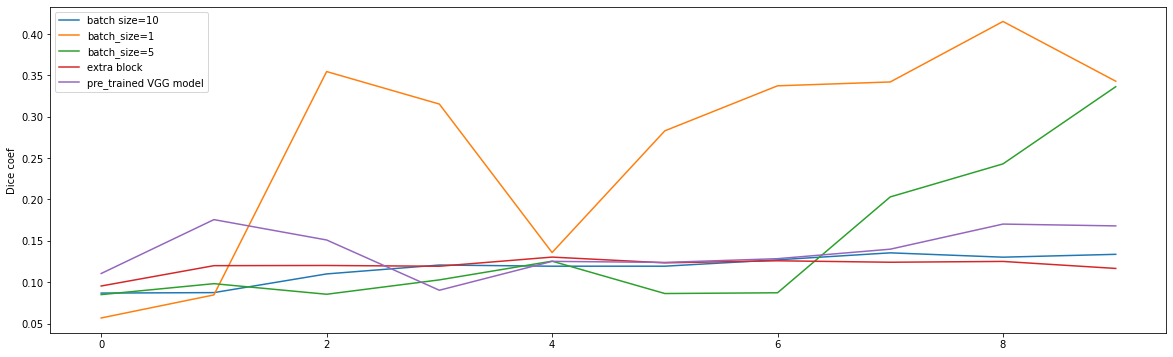

In [178]:
plt.figure(figsize=(20, 6))

plt.plot(history.history['val_dice_coef'], label='batch size=10')
plt.plot(history2.history['val_dice_coef'], label='batch_size=1')
plt.plot(history3.history['val_dice_coef'], label='batch_size=5')
plt.plot(history4.history['val_dice_coef'], label='extra block')
plt.plot(history5.history['val_dice_coef'], label='pre_trained VGG model')
plt.ylabel('Dice coef')
plt.legend()
plt.show()

In [92]:
history6 = modelU.fit(X_train, y_train, epochs=100, batch_size=5, validation_data=(X_test, y_test))

Epoch 1/100
8/8 [==============================] - 5s 467ms/step - loss: 1.9740 - dice_coef: 0.2450 - val_loss: 2.9179 - val_dice_coef: 0.1972
Epoch 2/100
8/8 [==============================] - 3s 368ms/step - loss: 1.2379 - dice_coef: 0.4954 - val_loss: 3.4276 - val_dice_coef: 0.2300
Epoch 3/100
8/8 [==============================] - 3s 404ms/step - loss: 1.0031 - dice_coef: 0.5699 - val_loss: 3.7119 - val_dice_coef: 0.2052
Epoch 4/100
8/8 [==============================] - 3s 403ms/step - loss: 0.8786 - dice_coef: 0.6039 - val_loss: 4.5213 - val_dice_coef: 0.1722
Epoch 5/100
8/8 [==============================] - 3s 404ms/step - loss: 0.7981 - dice_coef: 0.6534 - val_loss: 4.6573 - val_dice_coef: 0.1647
Epoch 6/100
8/8 [==============================] - 3s 403ms/step - loss: 0.7389 - dice_coef: 0.6738 - val_loss: 5.6544 - val_dice_coef: 0.0886
Epoch 7/100
8/8 [==============================] - 3s 403ms/step - loss: 0.6666 - dice_coef: 0.6983 - val_loss: 4.9320 - val_dice_coef: 0.1243

In [96]:
history7 = model.fit(X_train, y_train, epochs=100, batch_size=5, validation_data=(X_test, y_test))

Epoch 1/100
8/8 [==============================] - 11s 1s/step - loss: 1.7759 - dice_coef: 0.2940 - val_loss: 3.0506 - val_dice_coef: 0.0872
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 1.2486 - dice_coef: 0.4693 - val_loss: 11.4607 - val_dice_coef: 0.1192
Epoch 3/100
8/8 [==============================] - 7s 923ms/step - loss: 1.0856 - dice_coef: 0.5109 - val_loss: 54.9918 - val_dice_coef: 0.1185
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 1.0303 - dice_coef: 0.5340 - val_loss: 16.8380 - val_dice_coef: 0.0792
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 0.9635 - dice_coef: 0.5863 - val_loss: 23.1788 - val_dice_coef: 0.0362
Epoch 6/100
8/8 [==============================] - 7s 923ms/step - loss: 0.8925 - dice_coef: 0.5796 - val_loss: 3.3473 - val_dice_coef: 0.0951
Epoch 7/100
8/8 [==============================] - 7s 923ms/step - loss: 0.8967 - dice_coef: 0.5913 - val_loss: 3.1017 - val_dice_coef: 0.3021
Epoch 

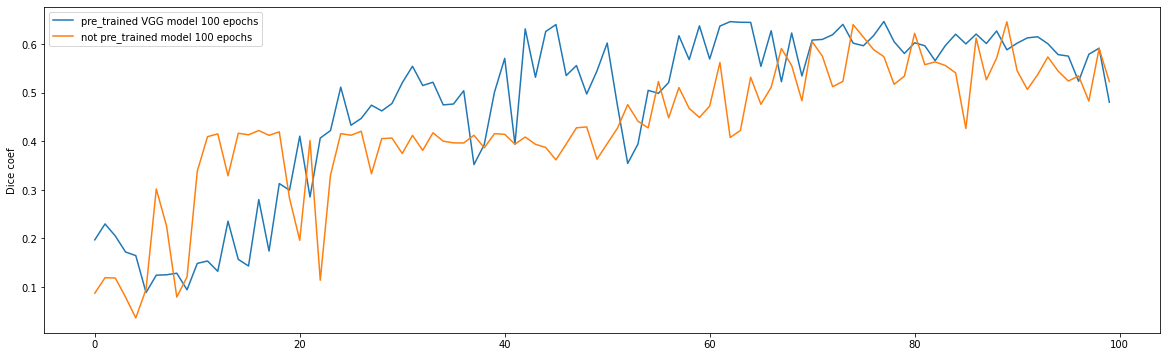

In [97]:
plt.figure(figsize=(20, 6))

plt.plot(history6.history['val_dice_coef'], label='pre_trained VGG model 100 epochs')
plt.plot(history7.history['val_dice_coef'], label='not pre_trained model 100 epochs')
plt.ylabel('Dice coef')
plt.legend()
plt.show()

In [119]:
# пробовала поменять активационную функцию, размер ядра и функцию потерь
def Unet(num_classes = 12, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = LeakyReLU(0.2)(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = LeakyReLU(0.2)(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = LeakyReLU(0.2)(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

 
    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(16, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)


    x = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [120]:
model3 = Unet(12, (256, 256, 3))

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_26[0][0]                   
__________________________________________________________________________________________________
batch_normalization_378 (BatchN (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
leaky_re_lu_92 (LeakyReLU)      (None, 256, 256, 64) 0           batch_normalization_378[0][0]    
___________________________________________________________________________________________

In [121]:
history8 = model3.fit(X_train, y_train, epochs=100, batch_size=5, validation_data=(X_test, y_test))

Epoch 1/100
8/8 [==============================] - 11s 1s/step - loss: 2.0438 - dice_coef: 0.1942 - val_loss: 3.9236 - val_dice_coef: 0.0722
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 1.6412 - dice_coef: 0.2788 - val_loss: 56.6773 - val_dice_coef: 0.0355
Epoch 3/100
8/8 [==============================] - 7s 932ms/step - loss: 1.4841 - dice_coef: 0.3240 - val_loss: 373.9883 - val_dice_coef: 0.0341
Epoch 4/100
8/8 [==============================] - 7s 931ms/step - loss: 1.3806 - dice_coef: 0.3572 - val_loss: 326.5761 - val_dice_coef: 0.0343
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 1.3281 - dice_coef: 0.3802 - val_loss: 195.4461 - val_dice_coef: 0.0332
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 1.2499 - dice_coef: 0.4064 - val_loss: 79.3280 - val_dice_coef: 0.0301
Epoch 7/100
8/8 [==============================] - 7s 931ms/step - loss: 1.1705 - dice_coef: 0.4331 - val_loss: 25.4888 - val_dice_coef: 0.1848
E

In [123]:
max(history6.history['val_dice_coef'])

0.6472686529159546

In [125]:
max(history7.history['val_dice_coef'])

0.646618127822876

In [127]:
max(history8.history['val_dice_coef'])

0.6704427599906921

Улучшить качество модели помогает подбор batch_size, кол-ва эпох, кол-ва блоков повышения и понижения. Из активационных функций пробовала relu и leaky_relu, из функций потерь - sparse_categorical_crossentropy и categorical_crossentropy - результаты примерно одинаковые (пик в последней модели кажется, скорее, случайным). Использование предобученной модели VGG16 не помогло улучшить результат, но позволяет выиграть в скорости обучения, требует меньше эпох. 